#**Importing Dependencies and the trained model**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from tensorflow.python.ops.math_ops import xdivy
from tensorflow.keras.layers import *
import IPython

#Order of emotion in one_hot: Anger, Disgust, Fear, Happy, Neutral, Sad
emotions = np.array(['ANG','DIS','FEA','HAP','NEU','SAD'])

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd '/content/gdrive/My Drive/Colab Notebooks/Voice_CNN/'

/content/gdrive/My Drive/Colab Notebooks/Voice_CNN


In [4]:
audiolength = np.load('audiolength.npy')
[min_a, max_a,max_length,entry] = np.load('stats.npy')

In [5]:
voicecnn = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Voice_CNN/6_2_2023_model')

In [6]:
voicecnn.summary()

Model: "cnn-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 79, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 256, 79, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 39, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 39, 64)       32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 19, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 19, 64)        65600 

# **Recording Audio from microphone**

In [7]:
cd '/content/gdrive/My Drive/Colab Notebooks/Voice_CNN/Audio_tests'

/content/gdrive/My Drive/Colab Notebooks/Voice_CNN/Audio_tests


In [26]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio_test.wav','wb') as f:
    f.write(b)
  return 'audio_test.wav'

In [27]:
audiooutput = record(10)


<IPython.core.display.Javascript object>

In [28]:
IPython.display.Audio('audio_test.wav')

# **Processing the audio**

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


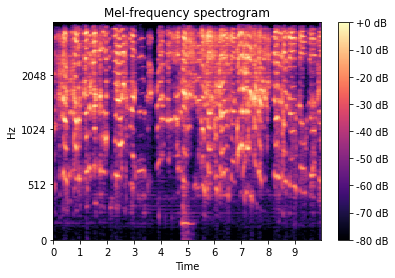

In [29]:
import librosa
import librosa.display

audio_data, sr = librosa.load('audio_test.wav', sr= 8000, mono=True)
melspectrum = librosa.feature.melspectrogram(y=audio_data, sr=sr, hop_length= 512, window='hann', n_mels=256)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(melspectrum, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [30]:
melspectrum = (np.log(np.array(melspectrum))-min_a)/(max_a-min_a)
melspectrum = np.nan_to_num(melspectrum, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

# **Processing the results**

In [31]:
predicted_emotions = np.zeros([6,melspectrum.shape[1]])
slices = np.empty([melspectrum.shape[1],256,int(max_length)])
for i in range(melspectrum.shape[1]):
  if (i+1)<max_length:
    section = np.concatenate((melspectrum[0:melspectrum.shape[0],:(i+1)],np.zeros([256,int(max_length)-(i+1)])), axis = 1)
  else:
    section = melspectrum[0:melspectrum.shape[0],(i-int(max_length)+1):(i+1)]
  slices[i] = section

In [32]:
output = voicecnn.predict(slices,batch_size = 32)

5/5 [==============================] - 12s 3s/step


In [33]:
output = output.swapaxes(0,1)

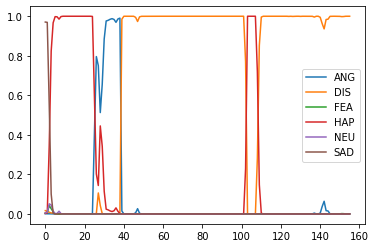

In [34]:
for i in range(len(emotions)):
  plt.plot(output[i], label = emotions[i])
plt.legend()
plt.show()

# **Weighted Output**

In [35]:
weights = np.array(range(int(max_length))) + 1

weights = np.power(np.e*weights/15,np.e)/np.exp(np.e*weights/15)

weights

array([8.03313343e-03, 4.41028878e-02, 1.10772097e-01, 2.01997854e-01,
       3.09081607e-01, 4.23260543e-01, 5.36890484e-01, 6.43905066e-01,
       7.39888870e-01, 8.21951003e-01, 8.88506468e-01, 9.39027330e-01,
       9.73798529e-01, 9.93696670e-01, 1.00000000e+00, 9.94231801e-01,
       9.78035922e-01, 9.53081375e-01, 9.20992087e-01, 8.83297697e-01,
       8.41401467e-01, 7.96561739e-01, 7.49883806e-01, 7.02319555e-01,
       6.54672692e-01, 6.07607775e-01, 5.61661652e-01, 5.17256221e-01,
       4.74711691e-01, 4.34259741e-01, 3.96056163e-01, 3.60192694e-01,
       3.26707867e-01, 2.95596804e-01, 2.66819896e-01, 2.40310414e-01,
       2.15981083e-01, 1.93729692e-01, 1.73443821e-01, 1.55004771e-01,
       1.38290783e-01, 1.23179635e-01, 1.09550702e-01, 9.72865430e-02,
       8.62741005e-02, 7.64055637e-02, 6.75789575e-02, 5.96985043e-02,
       5.26748026e-02, 4.64248592e-02, 4.08720072e-02, 3.59457354e-02,
       3.15814532e-02, 2.77202092e-02, 2.43083779e-02, 2.12973287e-02,
      

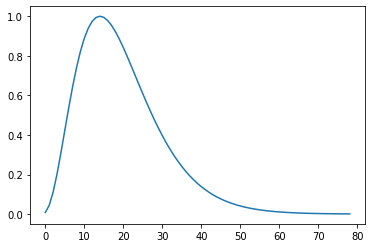

In [36]:
plt.plot(weights)
plt.show()

In [37]:
predicted_emotions = np.zeros([6,melspectrum.shape[1]])
slices = np.empty([melspectrum.shape[1]*int(max_length),256,int(max_length)])
for i in range(melspectrum.shape[1]):
  for j in range(min(int(max_length),i+1)):
    section = np.concatenate((melspectrum[0:melspectrum.shape[0],max(0,i-j):(i+1)],np.zeros([256,int(max_length)-j-1])), axis = 1)
    slices[i*int(max_length)+j] = section

In [38]:
from librosa.feature.spectral import melspectrogram
predicted_emotions = np.zeros([6,melspectrum.shape[1]])
output = voicecnn.predict(slices,batch_size = 32)
output = output.swapaxes(0,1)



386/386 [==============================] - 184s 476ms/step


In [39]:
for i in range(melspectrum.shape[1]):
  for j in range(6):
    predicted_emotions[j,i] = np.dot(output[j,i*int(max_length):
                                            i*int(max_length)+min(
                                                int(max_length),i+1
                                            )],weights[0:min(
                                                int(max_length),i+1
                                            )])
    total = weights[0:min(int(max_length),i)+1].sum()
    predicted_emotions[j,i] = predicted_emotions[j,i]/total

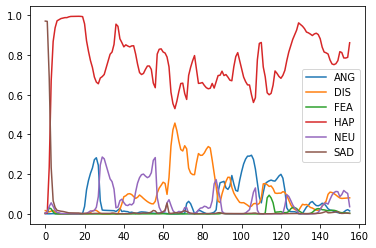

In [40]:
for i in range(len(emotions)):
  plt.plot(predicted_emotions[i], label = emotions[i])
plt.legend()
plt.show()